In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

In [2]:
# read data
dataset_raw = pd.read_csv('dataset_raw.csv')
weekly_equity_returns = pd.read_csv('weekly_equity_returns.csv')

In [3]:
# get gvkey in dataset_raw
companies_emission_data = dataset_raw['gvkey'].unique()

# filter gvkey in weekly_equity_return
weekly_equity_returns_f = weekly_equity_returns[weekly_equity_returns['gvkey'].isin(companies_emission_data)]

weekly_equity_returns_f['eow'] = pd.to_datetime(weekly_equity_returns_f['eow'])
weekly_equity_returns_f.sort_values(by=['gvkey', 'eow'], inplace=True)
weekly_equity_returns_f.set_index('eow', inplace=True)

C:\Users\18906\AppData\Local\Temp\ipykernel_16568\4128357845.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_equity_returns_f['eow'] = pd.to_datetime(weekly_equity_returns_f['eow'])
C:\Users\18906\AppData\Local\Temp\ipykernel_16568\4128357845.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_equity_returns_f.sort_values(by=['gvkey', 'eow'], inplace=True)


In [4]:
# take small samples for test
sample = weekly_equity_returns_f.iloc[0:30001]

In [5]:
# compute weekly return (group by 'gvkey')
weekly_equity_returns_f['weekly_return'] = weekly_equity_returns_f.groupby('gvkey')['Close_Price'].pct_change()

# compute weighted weekly return
weekly_equity_returns_f['weighted_return'] = weekly_equity_returns_f['weekly_return'] * weekly_equity_returns_f['Company_Market_Cap']

# compute market factors
market_factor = weekly_equity_returns_f.groupby('eow')['weighted_return'].sum() / weekly_equity_returns_f.groupby('eow')['Company_Market_Cap'].sum()

C:\Users\18906\AppData\Local\Temp\ipykernel_16568\1684815427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_equity_returns_f['weekly_return'] = weekly_equity_returns_f.groupby('gvkey')['Close_Price'].pct_change()
C:\Users\18906\AppData\Local\Temp\ipykernel_16568\1684815427.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_equity_returns_f['weighted_return'] = weekly_equity_returns_f['weekly_return'] * weekly_equity_returns_f['Company_Market_Cap']


<Axes: xlabel='eow'>

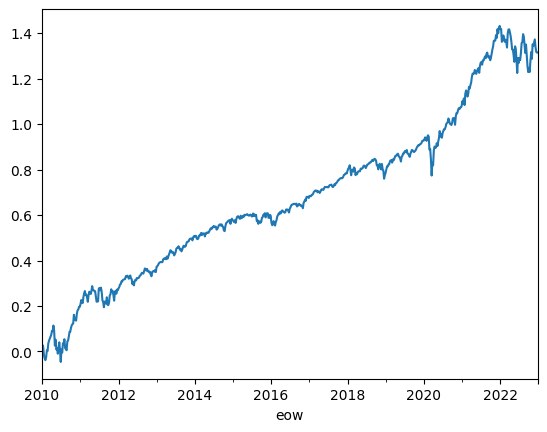

In [6]:
market_factor.cumsum().plot()

In [7]:
market_factor.dropna()
weekly_equity_returns_f.dropna(subset=['weekly_return'], inplace=True)

C:\Users\18906\AppData\Local\Temp\ipykernel_16568\686404713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_equity_returns_f.dropna(subset=['weekly_return'], inplace=True)


In [8]:
# initialize the linear regression
lm = LinearRegression()

# create ab empty DataFrame to store betas
index = pd.MultiIndex(levels=[[], []], codes=[[], []], names=['eow', 'gvkey'])
betas = pd.DataFrame(index=index, columns=['beta'])  

window = 52  # set the rolling window to be 52 weeks
count = 0

for gvkey in weekly_equity_returns_f['gvkey'].unique():
    
    gvkey_data = weekly_equity_returns_f[weekly_equity_returns_f['gvkey'] == gvkey].copy()

    # check the number of data points for each gvkey, make sure at least 52 data points
    if len(gvkey_data) < window:
        print(f"Skipping gvkey {gvkey} due to insufficient data")
        continue

    print(f"Processing gvkey: {gvkey}")  
    
    for end in range(window, len(gvkey_data)):
        window_data = gvkey_data.iloc[end-window:end]
        y = window_data['weekly_return'].values.reshape(-1, 1)

        # ensure market factors and stock data are aligned on the same week
        X = market_factor.loc[window_data.index].values.reshape(-1, 1) 

        # ensure enough changes in X
        if np.std(X) < 1e-8:
            print(f"Skipping window due to insufficient variation in market returns for gvkey {gvkey}")
            continue

        X = sm.add_constant(X)
        
        lm.fit(X, y)
        beta = lm.coef_[0][1]

        betas.loc[(window_data.index[-1], gvkey), 'beta'] = beta
    
    print(f"Completed gvkey: {gvkey}")  

print("Processed first 100 gvkeys")  

Processing gvkey: 1004
Completed gvkey: 1004
Processing gvkey: 1045
Completed gvkey: 1045
Processing gvkey: 1050
Completed gvkey: 1050
Processing gvkey: 1075
Completed gvkey: 1075
Processing gvkey: 1076
Completed gvkey: 1076
Processing gvkey: 1078
Completed gvkey: 1078
Processing gvkey: 1104
Completed gvkey: 1104
Processing gvkey: 1161
Completed gvkey: 1161
Processing gvkey: 1209
Completed gvkey: 1209
Processing gvkey: 1230
Completed gvkey: 1230
Processing gvkey: 1234
Completed gvkey: 1234
Processing gvkey: 1254
Completed gvkey: 1254
Processing gvkey: 1257
Completed gvkey: 1257
Processing gvkey: 1266
Completed gvkey: 1266
Processing gvkey: 1274
Completed gvkey: 1274
Processing gvkey: 1300
Completed gvkey: 1300
Processing gvkey: 1327
Completed gvkey: 1327
Processing gvkey: 1380
Completed gvkey: 1380
Processing gvkey: 1393
Completed gvkey: 1393
Processing gvkey: 1410
Completed gvkey: 1410
Processing gvkey: 1414
Completed gvkey: 1414
Processing gvkey: 1439
Completed gvkey: 1439
Processing

In [17]:
print(type(betas))

<class 'pandas.core.frame.DataFrame'>


In [26]:
for col in betas.columns:
    betas[col] = pd.to_numeric(betas[col], errors='coerce')

In [27]:
betas.describe()

,beta
count,1.374035e+06
mean,1.110893e+00
std,4.051371e+01
min,-9.490625e+03
25%,6.634153e-01
50%,1.045552e+00
75%,1.479388e+00
max,9.224654e+03


In [50]:
betas_w = winsorize(betas['beta'], limits=(0.001,0.001))
betas_w_df = pd.DataFrame(betas_w, index=betas.index, columns=['winsorized_beta'])

betas['winsorized_beta'] = betas_w

In [51]:
betas

,,beta,winsorized_beta
eow,gvkey,,
2010-12-31,1004,1.806286,1.806286
2011-01-07,1004,1.750517,1.750517
2011-01-14,1004,1.746333,1.746333
2011-01-21,1004,1.789419,1.789419
2011-01-28,1004,1.790238,1.790238
...,...,...,...
2022-11-25,328795,0.767960,0.767960
2022-12-02,328795,0.777149,0.777149
2022-12-09,328795,0.806873,0.806873


In [52]:
betas.describe()

c:\Users\18906\Python\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\18906\Python\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


,beta,winsorized_beta
count,1.374035e+06,1.374035e+06
mean,1.110893e+00,1.113518e+00
std,4.051371e+01,7.730116e-01
min,-9.490625e+03,-2.754873e+00
25%,6.634153e-01,6.634153e-01
50%,1.045552e+00,1.045552e+00
75%,1.479388e+00,1.479388e+00
max,9.224654e+03,6.283717e+00


In [53]:
betas.to_csv('./betas.csv', index=True)